----
### 05. Results Analysis

**Objective:**  To analyse the trained and tuned models and their performances and select the best model readily for production. In addition, to conduct an in-depth analysis for the best-performing model and perform an unseen-data performance comparison for all models. Finally, to present a client API for utilisation of the recommended model for ease and convenience.

---

### 5.1 Loading Trained Models and Data

In [1]:
import sys
from operator import index
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  # go up from notebooks/ to project root
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.data_loader import load_data
from src.model import test_evaluation, compare_test_metrics

In [3]:
from pathlib import Path
from joblib import load

# Define paths
DATA_PATH = PROJECT_ROOT / "data"
MODELS_PATH = PROJECT_ROOT / "trained_models"

# Load datasets
X_train = load(DATA_PATH / "X_train.joblib")
X_test  = load(DATA_PATH / "X_test.joblib")
y_train = load(DATA_PATH / "y_train.joblib")
y_test  = load(DATA_PATH / "y_test.joblib")

In [4]:

# Shapes check
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845,), (56962, 30), (56962,))

In [5]:

# Load baseline models
lr_baseline   = load(MODELS_PATH / "logistic_regression_baseline.joblib")
catboost_default = load(MODELS_PATH / "catboost_default.joblib")
lightgbm_default = load(MODELS_PATH / "lightgbm_default.joblib")
rf_default       = load(MODELS_PATH / "random_forest_default.joblib")

# Load tuned models
rf_tuned    = load(MODELS_PATH / "random_forest_tuned_for_pr_auc.joblib")
lightgbm_tuned  = load(MODELS_PATH / "lightgbm_tuned_for_pr_auc.joblib")
catboost_tuned  = load(MODELS_PATH / "catboost_tuned_for_pr_auc.joblib")


----
### 5.2 Production Model Selection Based on OOF Performance Analysis

The table below displays OOF metrics `(positive-class metrics only)` as produced by the OOF comparison at the end on modelling section, `sorted descending by val PR AUC`.


In [6]:
load_oof_val_metrics = True

if load_oof_val_metrics:
    TABLES_PATH = PROJECT_ROOT / "results" / "tables"
    oof_val_metrics = load_data(TABLES_PATH / "oof_validation_metrics_all_models.csv")

oof_val_metrics

,model,precision,recall,f1-score,support,oof pr auc (fraud)
0,LightGBM (Tuned),0.940,0.832,0.883,394.0,0.863
1,CatBoost (Tuned),0.960,0.802,0.874,394.0,0.856
2,LightGBM (Default),0.827,0.838,0.832,394.0,0.848
3,Random Forest (Tuned),0.881,0.805,0.841,394.0,0.839
4,CatBoost (Default),0.798,0.853,0.825,394.0,0.832
5,Random Forest (Default),0.835,0.810,0.822,394.0,0.803
6,Logistic Regression (Baseline),0.053,0.893,0.100,394.0,0.756


#### Production Candidate:
The tuned `LightGBM (Tuned)`model achieved the highest OOF PR AUC (0.863) and the highest F1-score for `the positive (fraud) class`:

- Precision = 0.94 for `the positive class` indicating a high proportion of predicted positives are true positives.

- Recall = 0.832 for `the positive class` indicating high coverage of actual positives. This combination of metrics makes it the best candidate for production.

In [7]:
oof_val_metrics.iloc[[0],:]

,model,precision,recall,f1-score,support,oof pr auc (fraud)
0,LightGBM (Tuned),0.94,0.832,0.883,394.0,0.863


In [8]:
production_model = lightgbm_tuned

-----

### 5.3 Production Model OOF Diagnostics (PR curve, Precision-Recall vs. Thresholds)



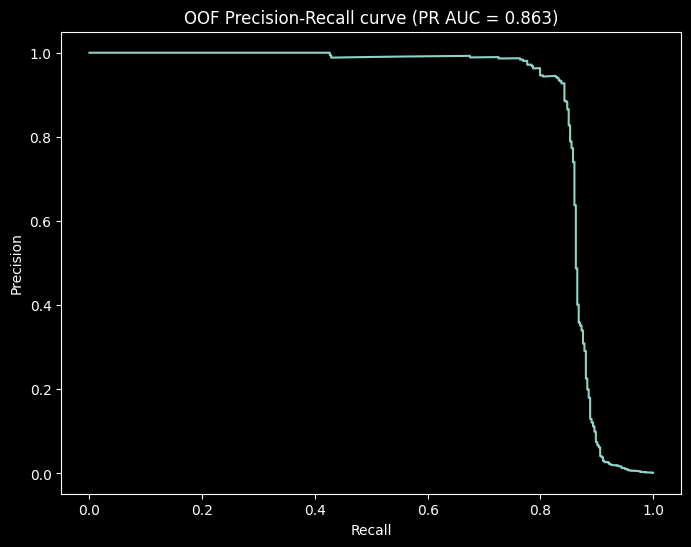

In [9]:
from src.model import pr_curve_oof, pr_vs_threshold_curve_oof

pr_auc_best_model_oof, oof_y_probabilities_best_model = pr_curve_oof(production_model, X_train, y_train, data_type="OOF")

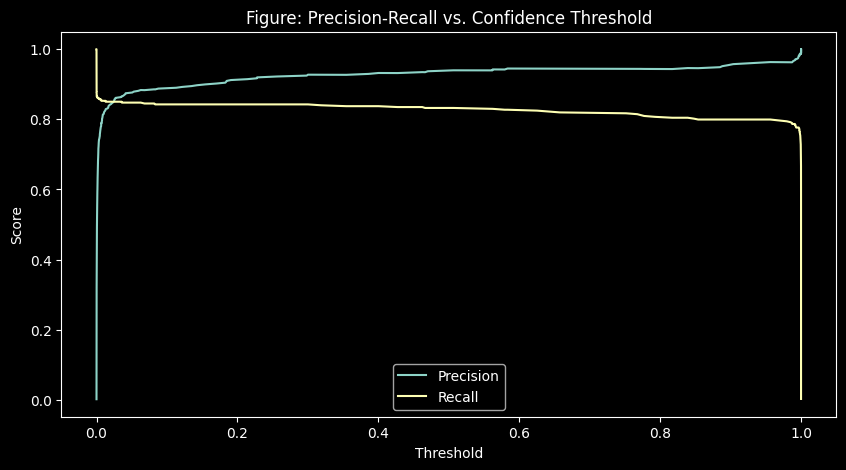

In [10]:
pr_vs_threshold_curve_oof(y_train, oof_y_probabilities_best_model)

---
### 5.4 OOF Probabilities Calibration
(How Accurate Are the Probabilities Produced by the Model ?)
#### Brier Score
Brier Score is the mean squared error between predicted probability and the actual label (0 or 1). It measures how close the predicted probabilities are to the true outcomes:

In [11]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_train, oof_y_probabilities_best_model)

brier_score

0.00036867656628361713

**Analysis:**
- Near perfect model brier score = 0, worse models have higher values (up to 1).
- The selected production model's brier score is calculated using `Out-of-fold (OOF) probabilities`.
- The score is `very low` `~0.00037` which means the predicted OOF probabilities are almost identical to the true outcomes/lables.
- This extremely low brier score means the model produces **realistic probabilites**, hence no further probability calibration is required. `Model probabilities output reflects a true likelihood of fraud.`

---
### 5.5 Risk-Based Client API Design (High / Medium / Low)

Based on the results of the OOF probabilities calibration, the selected production model produces reliable and realistic probabilities which can be directly interpreted as true risk levels. As a result I am designing a Probability-Based Fraud Risk Tier API (Low / Medium / High) for end user/client.

***Tiered API Thresholds Selection and Validation***. The Proposed thresholds are:

- High Risk: ≥ 0.80
- Medium Risk: 0.40 or 0.30 to 0.80
- Low Risk: < 0.40 or 0.30

In [12]:
len(oof_y_probabilities_best_model)

227845

In [13]:
# Check how many instances fall into High / Medium / Low tiers and adjust the threshold for appropriate coverage

from src.model import validate_thresholds

validate_thresholds(oof_y_probabilities_best_model)

,Percent
High,0.15
Medium,0.01
Low,99.84


**Analysis and Outcomes**

The prevalence of fraud instances in the dataset is very small with `fraud = 0.173%`. And as concluded earlier the Model's probabilities are calibrated (`OOF Brier = 0.00037`). When I investigated the distribution of produced probabilities I observed the following (as in the table above):

- High probability spectrum almost all fraud transactions correctly have high produced probabilities (≥0.80).
- Low probability Non-fraud cases correctly have very low predicted probabilities.
- Medium probability very few probabilities in the  mid-range(0.30 to 0.80).

Because of these facts and the distribution, I considered expanding the Medium Risk cutoff from 0.40 down to 0.30, however this did not grow the volume of  Medium Risk  instances. This means that the model produces binary probability distribution (high or low). Transactions are either have very low probabilities (non fraud) or very high probabilities (fraud ) with almost little to no confused cases (medium probs). To strike  a balance between interpretability and coverage I decided to keep the thresholds as:

1. High Fraud Risk ≥0.80

2. Medium Fraud Risk 0.30 to 0.80

3. Low Fraud Risk <0.30

-----
### 5.6 Test Set/Unseen Data Comparative Analysis (Positive Class Metrics)

Purpose: Evaluate all candidate models on the holdout test set, focusing on the positive (fraud) class. Extract positive class metrics from each model’s test confusion matrix and rank models by PR AUC.


In [14]:
# Suppress LightGBM feature name warnings globally
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)

In [15]:
from src.model import test_evaluation, compare_test_metrics

compare_test_metrics({"Logistic Regression (Baseline)": lr_baseline,
                      "CatBoost (Default)": catboost_default,
                      "LightGBM (Default)": lightgbm_default,
                      "Random Forest (Default)": rf_default,
                      "CatBoost (Tuned)": catboost_tuned,
                      "LightGBM (Tuned)": lightgbm_tuned,
                      "Random Forest (Tuned)": rf_tuned},
                     X_test, y_test)

,precision,recall,f1-score,support,balanced accuracy,pr auc
LightGBM (Tuned),0.950,0.776,0.854,98.0,0.888,0.857
CatBoost (Tuned),0.986,0.735,0.842,98.0,0.867,0.843
LightGBM (Default),0.818,0.827,0.822,98.0,0.913,0.836
Random Forest (Default),0.878,0.806,0.840,98.0,0.903,0.833
Random Forest (Tuned),0.940,0.796,0.862,98.0,0.898,0.828
CatBoost (Default),0.672,0.816,0.737,98.0,0.908,0.811
Logistic Regression (Baseline),0.057,0.908,0.108,98.0,0.941,0.794


**Observations:**

- Compared to out-of-fold evaluation, there is a slight drop in PR AUC and recall and in F1 score on the test set (expected behavior). For example, the LightGBM model’s PR AUC decreased from 0.863 (OOF) to 0.857 (test).

- This drop is small and expected due to natural generalization on unseen data.

- Noticeable Increase in precision as a trade-off of the decrease in recall.

Conclusion: The ranking based on PR AUC remains consistent with OOF results, confirming the selected model performs well on the test set.

---

### 5.7 Production Model Detailed Test Performance

#### Detailed Test Metrics Table

In [16]:
test_evaluation(production_model, X_test, y_test, model_name="LightGBM (Tuned)", print_c_matrix=False)

,precision,recall,f1-score,support,balanced accuracy,pr auc
Non-fraud (Class 0),1.000,1.000,1.000,56864.0,0.888,0.857
Fraud (Class 1),0.950,0.776,0.854,98.0,0.888,0.857
macro avg,0.975,0.888,0.927,56962.0,0.888,0.857


**Discussion:**

   - The table displays binary class performance Non-Fraud and Fraud.
   - Macro average is included to show the simple average across classes.
   - Support is shown to indicate the number of instances per class.

The macro-average provides a global metric reflective of the overall dataset.

#### Production Model's PR AUC for **Unseen test data**

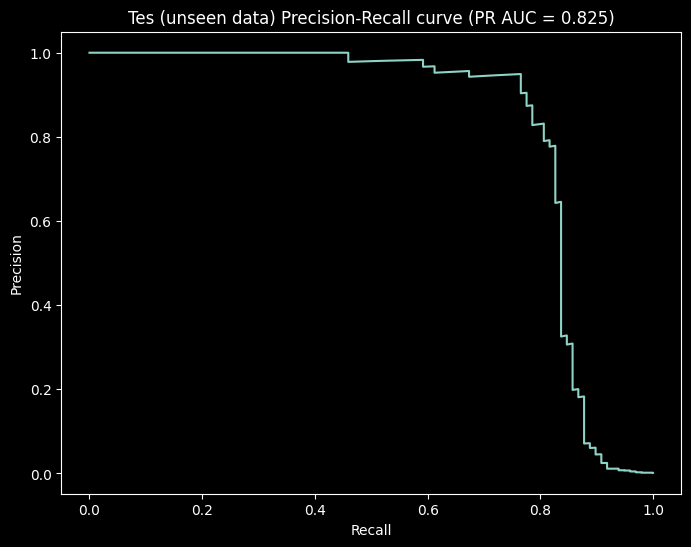

In [17]:
test_pr_auc_best_model, test_y_probabilities_best_model = pr_curve_oof(production_model, X_test, y_test, data_type="Tes (unseen data)")

#### Confusion Matrix (binary: fraud vs non-fraud)

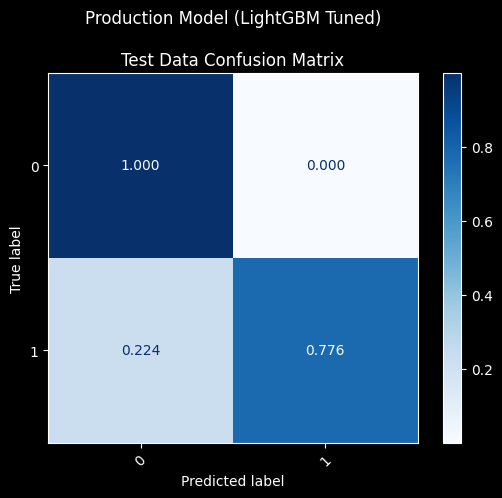

In [18]:
test_evaluation(production_model, X_test, y_test, model_name="Production Model (LightGBM Tuned)", print_c_matrix=True)

**Discussion**

- The displayed binary confusion matrix is normalized by class.

- True Positives percentage is 77.6%, and False Negative percentage is 22.4%. This aligns with the recall of test metrics.

- Negative class (Non-Fraud): Nearly all instances correctly classified.

Key insight: The model reliably identifies the minority (fraud) class, capturing the majority of fraud cases while keeping misclassification relatively low.

#### 2nd Best Performing Model (Catboost Tuned) Confusion Matrix

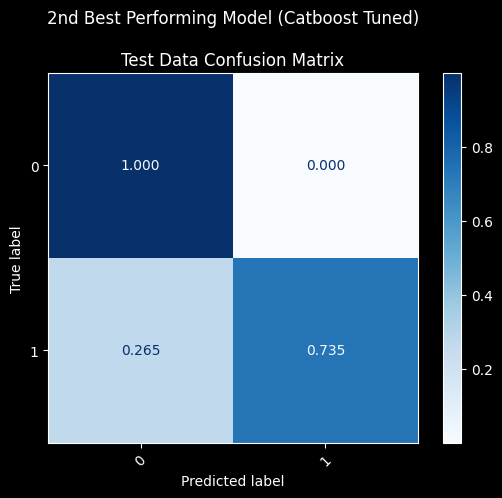

In [19]:
test_evaluation(catboost_tuned, X_test, y_test, model_name="2nd Best Performing Model (Catboost Tuned)", print_c_matrix=True)

CatBoost (Tuned) as the second best performing model compared to the production model:

- False Negatives (FN): percentage increased from 22.4% → 26.5%.
- True Positives (TP): percentage decreased correspondingly from 77.6% to 73.5%.

---
### 5.8 Feature Importance and Explainability

**Gain** measures how much a feature improves the model’s training objective (minimizing loss) when used to split a tree (higher gain means more contribution to reducing error). It shows which features the model (LightGBM) relied on most to separate fraud vs non-fraud (i.e. Most Important Predictors).

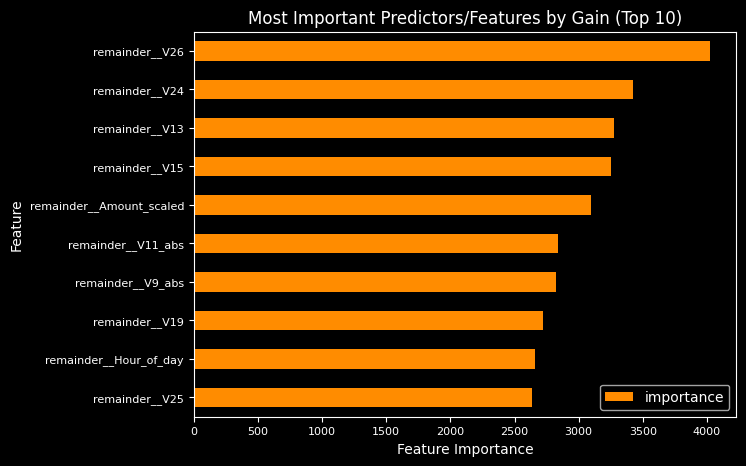

In [20]:
from src.model import feature_importance

most_important_features = feature_importance(production_model, X_train, y_train)

In [21]:
most_important_features

,feature,importance
21,remainder__V26,4027
19,remainder__V24,3420
11,remainder__V13,3275
13,remainder__V15,3251
43,remainder__Amount_scaled,3095
25,remainder__V11_abs,2841
23,remainder__V9_abs,2824
17,remainder__V19,2720
44,remainder__Hour_of_day,2657
20,remainder__V25,2633


**Discussion:**
- The chart and the table highlight the most important indicators of fraudlent/non-faulalnt credit cards transaction
- Top 10 features include 4 engineered features (40%).
- Engineered features (e.g. abs(V11), abs(V9), hour_of_day) materially improved predictive power.

- The Targeted feature engineering (creating features based on class separation behavior) worked: engineered features capture useful and impactful patterns.

----

### 5.9 Client API Smoke Test


In [22]:
from src.model import fraud_risk_assessment, smoke_test_sample

fraud_risk_assessment_table = fraud_risk_assessment(production_model, X_test)

In [23]:
fraud_risk_assessment_table.head()

,Fraud Probability,Risk Level,Risk Indicator,Action code,Action Text
Transaction ID,,,,,
2646,1.0,High,Red,BLOCK,Block transaction; initiate fraud protocol.
27831,1.0,High,Red,BLOCK,Block transaction; initiate fraud protocol.
1467,1.0,High,Red,BLOCK,Block transaction; initiate fraud protocol.
25261,1.0,High,Red,BLOCK,Block transaction; initiate fraud protocol.
51590,1.0,High,Red,BLOCK,Block transaction; initiate fraud protocol.


#### Extracting A Sample Covering All Risk Levels

In [24]:
smoke_test_sample(fraud_risk_assessment_table)

,Fraud Probability,Risk Level,Risk Indicator,Action code,Action Text
Transaction ID,,,,,
2646,1.00,High,Red,BLOCK,Block transaction; initiate fraud protocol.
27831,1.00,High,Red,BLOCK,Block transaction; initiate fraud protocol.
1467,1.00,High,Red,BLOCK,Block transaction; initiate fraud protocol.
25261,1.00,High,Red,BLOCK,Block transaction; initiate fraud protocol.
51590,1.00,High,Red,BLOCK,Block transaction; initiate fraud protocol.
51633,0.75,Medium,Amber,REVIEW,Flag for manual review.
46469,0.42,Medium,Amber,REVIEW,Flag for manual review.
4265,0.33,Medium,Amber,REVIEW,Flag for manual review.
32091,0.29,Low,Green,ALLOW,No action; process normally.


**Outcomes:**

The `Fraud Risk Assessment API` functions as designed, produces a clear, client-ready DataFrame with fraud probability risk level, risk indicator and actionable recommendations, accurately reflecting the tiered fraud risk design (i.e. Output schema matches expectations).

----

### 5.10 Final Summary

The recommended production model is the tuned GBM, chosen based on an in-depth comparative analysis of performance metrics for all candidate models. Out-of-fold evaluation and test evaluation on unseen holdout data confirmed that this model remains the best performing candidate, with PR AUC of 0.863 (OOF) and 0.857 (test).

This project effectively addresses the severe class imbalance (fraud prevalence = 0.173 of transactions) and present strong `positive-class` metrics: `test` PR AUC = 0.857, precision = 0.95, recall = 0.776. Feature engineering played a critical role with 40% of the top predictors being engineered features, noticeably enhancing model performance. A client-facing API was built and tested to provide fraud probability, risk level, risk indicator, and actionable recommendations in a three-tiered design (high: ≥0.80, medium: 0.30–0.80, low: <0.30). It was validated using a smoke test covering all risk levels. The API outputs are consistent, interpretable and aligned with business environment.

Overall, the solution is production-ready, supported by reproducible OOF and test evaluations, explainability through feature importance, and a simple operational API for client use.

--------------
### 5.11 Executive Summary and Supplementary Results

For a high-level overview of this Fraud Risk Modeling Project please refer to the **Fraud_Risk_Modeling_Executive_Summary.pdf** located in the `results/` directory. Furthermore supporting metrics tables and visualizations are available in the subdirectories:
- `results/tables/`: All performance, confusion matrix and feature importance tables.
- `results/plots/`: All charts, PR curves and feature importance plots.

-----------
-----